<a href="https://colab.research.google.com/github/kyohei-123/autoencoder-test/blob/master/cifar_deep_R1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixing of supervised and unsupervised learning!

#Introduction
In this notebook, supervised and unsupervised mixing method is introduced for cifar10 classification.   
Likns below helped me a lot.

Ref1
https://www.tensorflow.org/tutorials/images/cnn  
Ref2 https://deepage.net/deep_learning/2016/10/09/deeplearning_autoencoder.html　　  
Ref3 http://ipr20.cs.ehime-u.ac.jp/column/neural/chapter6.html  
Ref4 https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763　　　

Ref https://sefiks.com/2018/03/23/convolutional-autoencoder-clustering-images-with-neural-networks/　　  
Ref https://qiita.com/slowsingle/items/bb1671d4a6b19820db5c  

#Prep

In [118]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from  sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [252]:
### Load data

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1aa
train_images, test_images = train_images / 255.0, test_images / 255.0



In [253]:
### Prep data
### 2500 training data for bird, deer, truck
### 5000 train data for each remainig 7 classes
### 1000 test data for each 10 class

bird_indexes = [i for i, label in enumerate(train_labels) if label==2]
deer_indexes = [i for i, label in enumerate(train_labels) if label==4]
truck_indexes = [i for i, label in enumerate(train_labels) if label==9]
other_indexes = [i for i, label in enumerate(train_labels) if label in (0,1,3,5,6,7,8)] 

train_images_bird, _ = train_test_split(train_images[bird_indexes],train_size=0.5,random_state=0)
train_images_deer, _ = train_test_split(train_images[deer_indexes],train_size=0.5,random_state=0)
train_images_truck, _ = train_test_split(train_images[truck_indexes],train_size=0.5,random_state=0)

train_images = np.vstack([train_images_bird, train_images_deer, train_images_truck, train_images[other_indexes]])
train_labels = np.vstack([(np.ones((2500,1))*2).astype(int), (np.ones((2500,1))*4).astype(int), 
                          (np.ones((2500,1))*9).astype(int), train_labels[other_indexes]])

train_labels_cat = train_labels.copy()
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

train_images, train_labels, train_labels_cat = shuffle(train_images, train_labels, train_labels_cat, random_state=0)

print(f"data all # : {train_images.shape}")
print(f"birds data # : {train_images_bird.shape}")
print(f"deers data # : {train_images_deer.shape}")
print(f"trucks data # : {train_images_truck.shape}")
print(f"image.shape = {train_images[0].shape}")

picture_shape = train_images[0].shape



data all # : (42500, 32, 32, 3)
birds data # : (2500, 32, 32, 3)
deers data # : (2500, 32, 32, 3)
trucks data # : (2500, 32, 32, 3)
image.shape = (32, 32, 3)


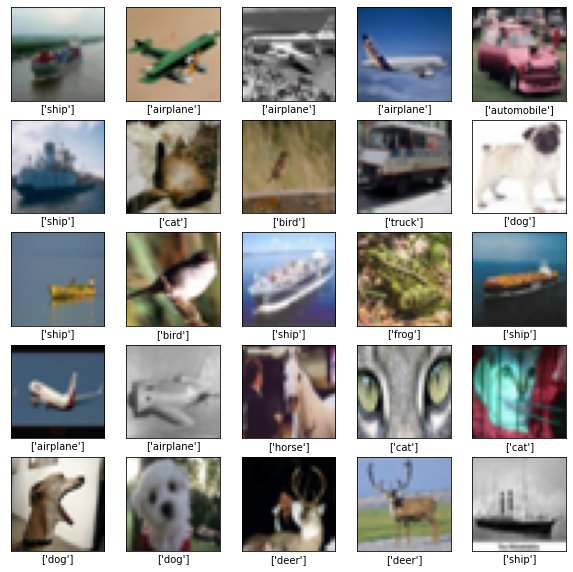

In [5]:
### check labeling

class_names = pd.Series(['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i].astype(bool)].values)
plt.show()


#Autoencoder

In [13]:
### Make autoencoder

### Make encoder
input_img = keras.Input(shape=picture_shape)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(input_img)
x = layers.MaxPool2D(pool_size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

encoded = x

### Make decoder
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.UpSampling2D(size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same')(x)

decoded = x

### Combine
autoencoder = keras.Model(inputs=input_img, outputs=decoded)
encoder = keras.Model(inputs=input_img, outputs=encoded)

print(autoencoder.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 3)         219       
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
_________________________________________________________

In [14]:
### Train autoencoder

autoencoder.compile(optimizer='adam',
                    loss=keras.losses.mean_squared_error,
                    metrics=['accuracy'])

history_autoencoder = autoencoder.fit(train_images, train_images,
                epochs=10,
                shuffle=True,
                batch_size=256,
                validation_data=(test_images,test_images))


Epoch 1/10
167/167 [==============================] - 32s 190ms/step - loss: 0.0883 - accuracy: 0.3578 - val_loss: 0.0092 - val_accuracy: 0.5813
Epoch 2/10
167/167 [==============================] - 32s 194ms/step - loss: 0.0078 - accuracy: 0.6029 - val_loss: 0.0057 - val_accuracy: 0.6148
Epoch 3/10
167/167 [==============================] - 32s 194ms/step - loss: 0.0054 - accuracy: 0.6359 - val_loss: 0.0046 - val_accuracy: 0.6510
Epoch 4/10
167/167 [==============================] - 33s 196ms/step - loss: 0.0043 - accuracy: 0.6634 - val_loss: 0.0035 - val_accuracy: 0.7158
Epoch 5/10
167/167 [==============================] - 32s 189ms/step - loss: 0.0034 - accuracy: 0.7300 - val_loss: 0.0031 - val_accuracy: 0.7454
Epoch 6/10
167/167 [==============================] - 32s 193ms/step - loss: 0.0030 - accuracy: 0.7568 - val_loss: 0.0028 - val_accuracy: 0.7677
Epoch 7/10
167/167 [==============================] - 33s 198ms/step - loss: 0.0028 - accuracy: 0.7662 - val_loss: 0.0026 - val_ac

In [15]:
autoencoder.save('saved_model/autoencoder.h5')

Best Validation Loss: 0.0022
Best Validation Accuracy: 0.7900


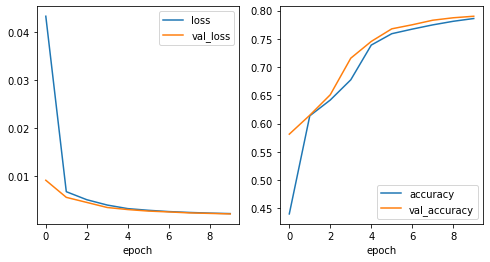

In [17]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_autoencoder_df = pd.DataFrame(history_autoencoder.history)

check_history(history_autoencoder_df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'autoencodered')

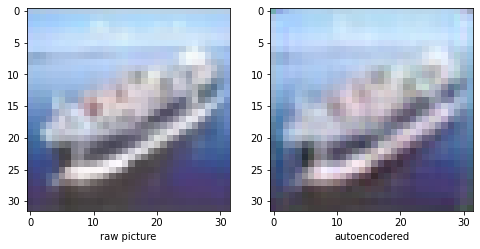

In [18]:
i = 12
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(train_images[i])
plt.xlabel('raw picture')
plt.subplot(1,2,2)
plt.imshow(autoencoder.predict(train_images[[i]]).reshape(32,32,3))
plt.xlabel('autoencodered')



Ok, seems my autoencoder works well!

#CNN with Encoder

In [19]:
### Build CNN with input from encoder

encoder.trainable = False ### I don't want update my trained encoder.

cnn = keras.Sequential()
cnn.add(encoder)
cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(10))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 16, 16, 8)         224       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        4672      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

My cnn has 110K trainable parameters. My baseline model shoud have same number of parameters so that they are comparable.

In [20]:
cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=256, shuffle=True)

Epoch 1/10
167/167 [==============================] - 13s 75ms/step - loss: 1.9831 - accuracy: 0.2808 - val_loss: 1.8312 - val_accuracy: 0.3358
Epoch 2/10
167/167 [==============================] - 11s 67ms/step - loss: 1.5715 - accuracy: 0.4335 - val_loss: 1.5977 - val_accuracy: 0.4047
Epoch 3/10
167/167 [==============================] - 11s 67ms/step - loss: 1.4325 - accuracy: 0.4869 - val_loss: 1.6289 - val_accuracy: 0.4356
Epoch 4/10
167/167 [==============================] - 11s 65ms/step - loss: 1.3670 - accuracy: 0.5143 - val_loss: 1.6362 - val_accuracy: 0.4115
Epoch 5/10
167/167 [==============================] - 11s 65ms/step - loss: 1.3429 - accuracy: 0.5210 - val_loss: 1.6171 - val_accuracy: 0.4161
Epoch 6/10
167/167 [==============================] - 11s 64ms/step - loss: 1.3135 - accuracy: 0.5352 - val_loss: 1.3861 - val_accuracy: 0.5011
Epoch 7/10
167/167 [==============================] - 11s 68ms/step - loss: 1.1852 - accuracy: 0.5821 - val_loss: 1.2861 - val_accuracy:

Best Validation Loss: 1.2718
Best Validation Accuracy: 0.5513


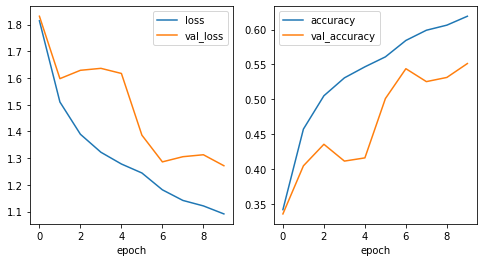

In [22]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

It seems the validation score is affected by the choice of data. Larger batch may help this.

In [23]:
cnn.save('saved_model/cnn.h5')

In [24]:
cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024, shuffle=True)

Epoch 1/10
42/42 [==============================] - 10s 233ms/step - loss: 1.1387 - accuracy: 0.5998 - val_loss: 1.1754 - val_accuracy: 0.5802
Epoch 2/10
42/42 [==============================] - 9s 224ms/step - loss: 1.0261 - accuracy: 0.6430 - val_loss: 1.1875 - val_accuracy: 0.5734
Epoch 3/10
42/42 [==============================] - 9s 208ms/step - loss: 1.0173 - accuracy: 0.6481 - val_loss: 1.1612 - val_accuracy: 0.5892
Epoch 4/10
42/42 [==============================] - 9s 208ms/step - loss: 1.0088 - accuracy: 0.6494 - val_loss: 1.1455 - val_accuracy: 0.5933
Epoch 5/10
42/42 [==============================] - 10s 233ms/step - loss: 0.9864 - accuracy: 0.6583 - val_loss: 1.1602 - val_accuracy: 0.5884
Epoch 7/10
42/42 [==============================] - 9s 213ms/step - loss: 0.9779 - accuracy: 0.6597 - val_loss: 1.1378 - val_accuracy: 0.5961
Epoch 8/10
42/42 [==============================] - 9s 223ms/step - loss: 0.9682 - accuracy: 0.6656 - val_loss: 1.1566 - val_accuracy: 0.5847
Epoc

In [26]:
cnn.save('saved_model/cnn.h5')

Best Validation Loss: 1.1076
Best Validation Accuracy: 0.6099


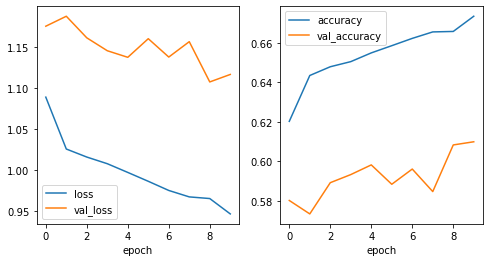

In [27]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

#CNN Baseline

In [53]:
np.argmax(basemodel.predict(train_images))

67181

In [8]:
### Check score of baseline model
### I defined my baseline model as below
### Ref: https://www.tensorflow.org/tutorials/images/cnn

basemodel = keras.models.Sequential()
basemodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))

basemodel.add(layers.Flatten())
basemodel.add(layers.Dense(64, activation='relu'))
basemodel.add(layers.Dense(10))

basemodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In my base cnn model above, trainable parameters are 120K, which are almost same for previous cnn with encoder input, which means those models are comparable.

In [9]:
basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=256,shuffle=True,
                  callbacks=[early_stopping]
                  )

Epoch 1/10
167/167 [==============================] - 18s 102ms/step - loss: 1.9620 - accuracy: 0.2762 - val_loss: 2.0039 - val_accuracy: 0.3262
Epoch 2/10
167/167 [==============================] - 15s 91ms/step - loss: 1.5028 - accuracy: 0.4664 - val_loss: 1.5234 - val_accuracy: 0.4512
Epoch 3/10
167/167 [==============================] - 14s 85ms/step - loss: 1.3165 - accuracy: 0.5324 - val_loss: 1.4303 - val_accuracy: 0.4904
Epoch 4/10
167/167 [==============================] - 17s 100ms/step - loss: 1.2026 - accuracy: 0.5726 - val_loss: 1.3930 - val_accuracy: 0.5129
Epoch 5/10
167/167 [==============================] - 19s 116ms/step - loss: 1.1753 - accuracy: 0.5896 - val_loss: 1.6087 - val_accuracy: 0.4629
Epoch 6/10
167/167 [==============================] - 17s 104ms/step - loss: 1.0987 - accuracy: 0.6184 - val_loss: 1.4300 - val_accuracy: 0.5253
Epoch 7/10
167/167 [==============================] - 19s 116ms/step - loss: 1.0602 - accuracy: 0.6290 - val_loss: 1.5840 - val_accu

Best Validation Loss: 1.0816
Best Validation Accuracy: 0.6162


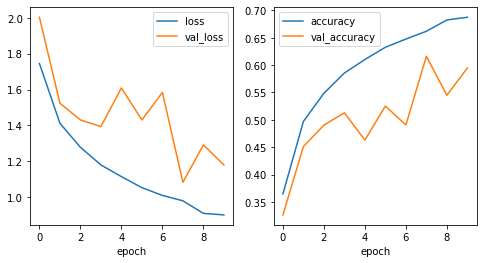

In [10]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

In [11]:
basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024,shuffle=True,
                  callbacks=[early_stopping]
                  )

Epoch 1/10
42/42 [==============================] - 15s 338ms/step - loss: 0.9607 - accuracy: 0.6715 - val_loss: 0.9865 - val_accuracy: 0.6539
Epoch 2/10
42/42 [==============================] - 13s 307ms/step - loss: 0.8153 - accuracy: 0.7187 - val_loss: 0.9890 - val_accuracy: 0.6536
Epoch 3/10
42/42 [==============================] - 13s 310ms/step - loss: 0.8007 - accuracy: 0.7266 - val_loss: 0.9739 - val_accuracy: 0.6610
Epoch 4/10
42/42 [==============================] - 13s 301ms/step - loss: 0.7889 - accuracy: 0.7314 - val_loss: 0.9568 - val_accuracy: 0.6652
Epoch 5/10
42/42 [==============================] - 13s 302ms/step - loss: 0.7784 - accuracy: 0.7309 - val_loss: 0.9732 - val_accuracy: 0.6604
Epoch 6/10
42/42 [==============================] - 13s 314ms/step - loss: 0.7613 - accuracy: 0.7377 - val_loss: 0.9490 - val_accuracy: 0.6693
Epoch 7/10
42/42 [==============================] - 12s 292ms/step - loss: 0.7489 - accuracy: 0.7441 - val_loss: 0.9938 - val_accuracy: 0.6571

Best Validation Loss: 0.9403
Best Validation Accuracy: 0.6739


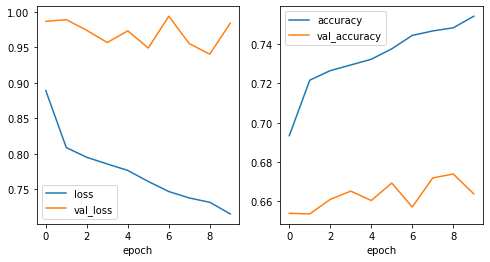

In [12]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

In [16]:
basemodel.save('saved_model/basemodel.h5')

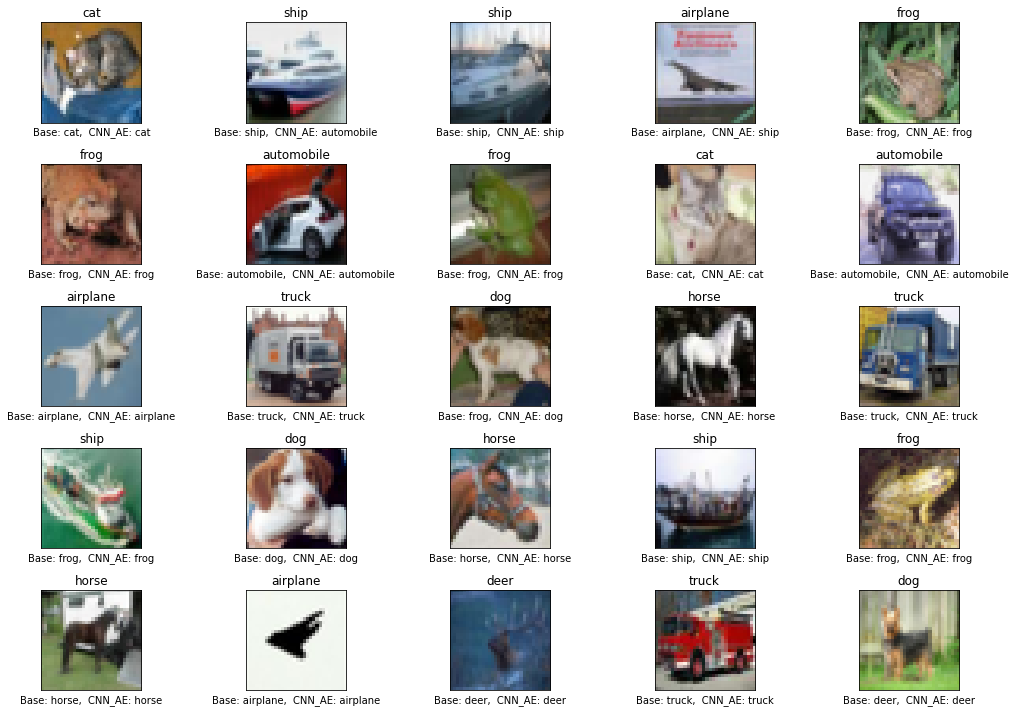

In [72]:
# i = 6
plt.figure(figsize=(15,10),tight_layout=True)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(test_images[i])
    res_base = class_names[np.argmax(basemodel.predict(test_images[[i]]))]
    res_cnn = class_names[np.argmax(cnn.predict(test_images[[i]]))]
    plt.xlabel(f"Base: {res_base},  CNN_AE: {res_cnn}")
    plt.title(class_names[np.argmax(test_labels[i])])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [79]:
test_pred_cnn = cnn.predict(test_images)
test_pred_basemodel = basemodel.predict(test_images)

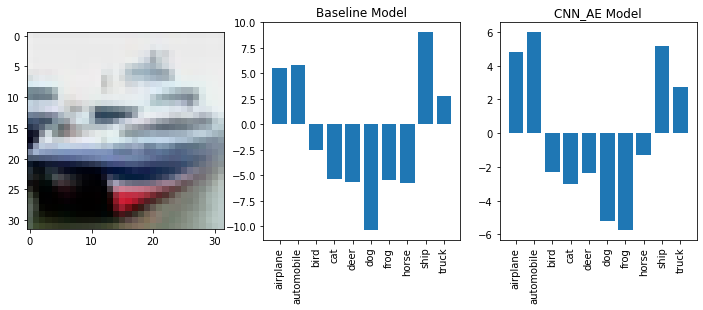

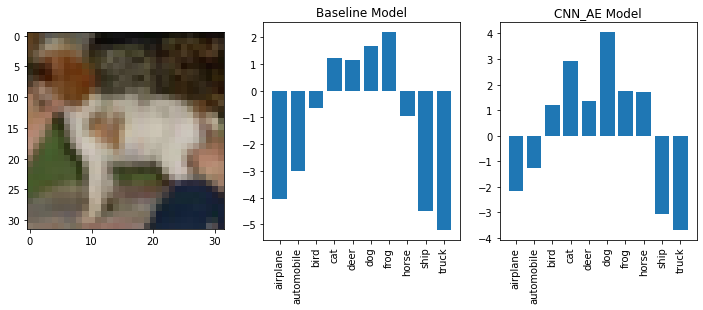

In [116]:
### Check how much confident my models predict each test data

i=1
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_images[i])
plt.subplot(1,3,2)
plt.bar(x = class_names, height = test_pred_basemodel[i])
plt.xticks(rotation=90)
plt.title('Baseline Model')
plt.subplot(1,3,3)
plt.bar(x = class_names, height = test_pred_cnn[i])
plt.xticks(rotation=90)
plt.title('CNN_AE Model')
plt.show()

i=12
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_images[i])
plt.subplot(1,3,2)
plt.bar(x = class_names, height = test_pred_basemodel[i])
plt.xticks(rotation=90)
plt.title('Baseline Model')
plt.subplot(1,3,3)
plt.bar(x = class_names, height = test_pred_cnn[i])
plt.xticks(rotation=90)
plt.title('CNN_AE Model')
plt.show()

Ah, ok my models can distinguish between "animal" and "machine", but diffcult to tell which "machine" or which "animal" it is. 

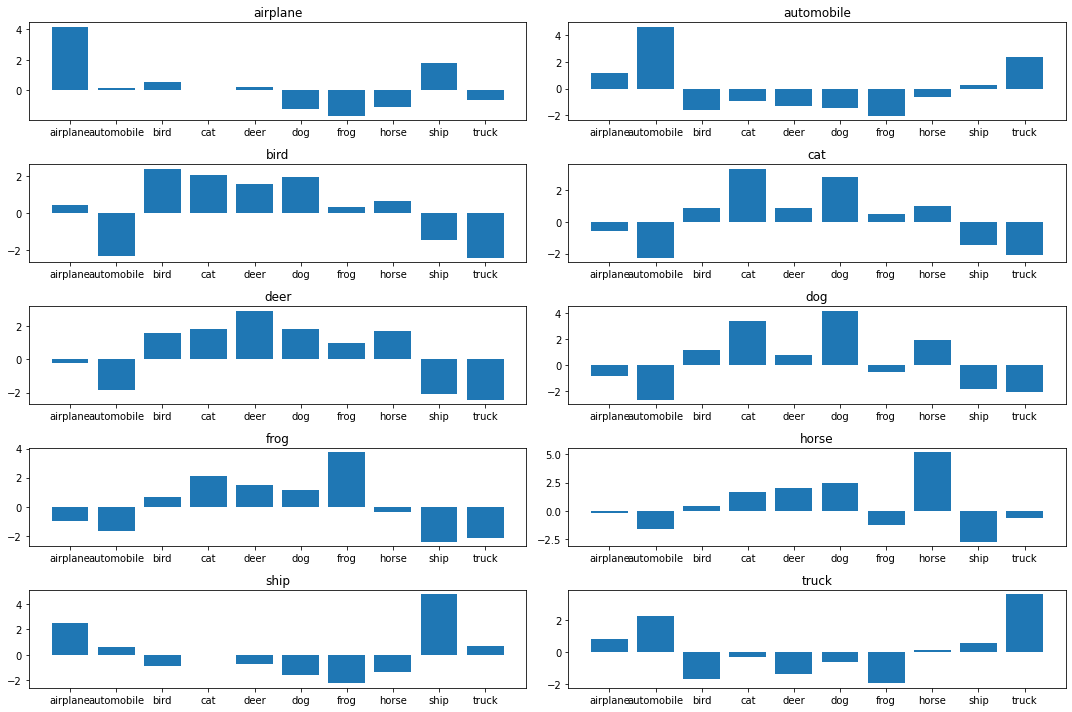

In [115]:
### Check how much confident my models predict each test data

result_df = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df = pd.concat([result_df, pd.DataFrame(test_pred_cnn,columns = class_names)],axis=1)

# label = "airplane"
plt.figure(figsize=(15,10),tight_layout=True)
for i,label in enumerate(class_names):
    filter = result_df[label+"_label"]==1
    plt.subplot(5,2,i+1)
    plt.bar(x=class_names, height = result_df[filter][class_names].mean())
    plt.title(label)

Ok, my model has difficulty to distinguish bird, cat, dog and deer. Maybe I can improve my model by augmenting data. I hope I can improve my model for deer since they have distinct feature.

In [222]:
### Data augmentation (2times of bird, dog, cat and deer)
### In animal pictures, many pausings can be found. Therefore, animal's rotation will not be important feature, so I will augment animal pictures by rotation.


def func_augment(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # ImageDataGeneratorの生成
    datagen = ImageDataGenerator(
        rotation_range=20
    )

    g = datagen.flow(x, batch_size=1)
    batch=[]
    for i in range(1):
        batch.append(g.next())
    return batch
# i = 0
# x = train_images[i]
# y = func_augment(x)[0]

In [244]:
### bird
filter = np.where(train_labels_cat==2)[0]
bird_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    bird_adds = np.vstack((bird_adds,func_augment(img)[0]))

### cat
filter = np.where(train_labels_cat==3)[0]
cat_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    cat_adds = np.vstack((cat_adds,func_augment(img)[0]))

### deer
filter = np.where(train_labels_cat==4)[0]
deer_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    deer_adds = np.vstack((deer_adds,func_augment(img)[0]))

### dog
filter = np.where(train_labels_cat==5)[0]
dog_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    dog_adds = np.vstack((dog_adds,func_augment(img)[0]))

In [256]:
train_images = np.vstack([train_images,bird_adds,cat_adds,deer_adds,dog_adds])
train_labels_cat = np.vstack([train_labels_cat, (np.ones((2500,1))*2).astype(int), (np.ones((5000,1))*3).astype(int), 
                          (np.ones((2500,1))*4).astype(int), (np.ones((5000,1))*5).astype(int)])

In [260]:
train_labels = keras.utils.to_categorical(train_labels_cat, 10)
train_images, train_labels, train_labels_cat = shuffle(train_images, train_labels, train_labels_cat, random_state=0)

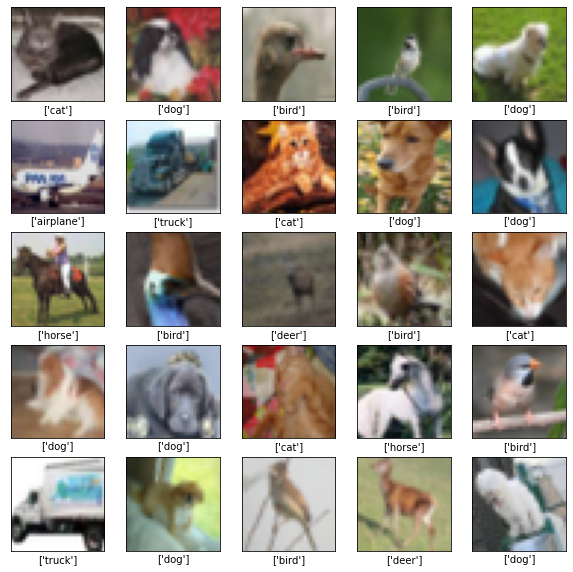

In [261]:
### check labeling

class_names = pd.Series(['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i].astype(bool)].values)
plt.show()


Epoch 1/10
57/57 [==============================] - 13s 222ms/step - loss: 1.0052 - accuracy: 0.6415 - val_loss: 1.1036 - val_accuracy: 0.6186
Epoch 2/10
57/57 [==============================] - 13s 225ms/step - loss: 0.9077 - accuracy: 0.6764 - val_loss: 1.0496 - val_accuracy: 0.6343
Epoch 3/10
57/57 [==============================] - 12s 217ms/step - loss: 0.9112 - accuracy: 0.6795 - val_loss: 1.0350 - val_accuracy: 0.6395
Epoch 4/10
57/57 [==============================] - 13s 227ms/step - loss: 0.8896 - accuracy: 0.6854 - val_loss: 1.0692 - val_accuracy: 0.6346
Epoch 5/10
57/57 [==============================] - 13s 228ms/step - loss: 0.8888 - accuracy: 0.6832 - val_loss: 1.0822 - val_accuracy: 0.6274
Epoch 6/10
57/57 [==============================] - 12s 214ms/step - loss: 0.8714 - accuracy: 0.6897 - val_loss: 1.0764 - val_accuracy: 0.6303
Epoch 7/10
57/57 [==============================] - 13s 222ms/step - loss: 0.8663 - accuracy: 0.6919 - val_loss: 1.0384 - val_accuracy: 0.6394

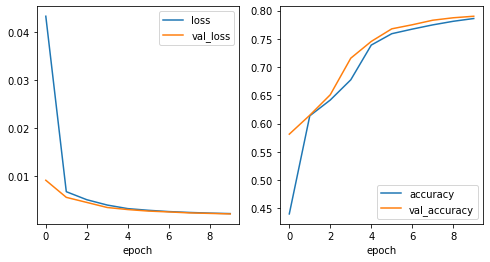

In [263]:
### CNN with Autoencoder

cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024, shuffle=True)

cnn.save('./saved_model/cnn_aug.h5')

### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_autoencoder_df = pd.DataFrame(history_autoencoder.history)

check_history(history_autoencoder_df)

Epoch 1/10
57/57 [==============================] - 18s 299ms/step - loss: 0.9326 - accuracy: 0.6732 - val_loss: 0.9195 - val_accuracy: 0.6812
Epoch 2/10
57/57 [==============================] - 18s 308ms/step - loss: 0.7658 - accuracy: 0.7283 - val_loss: 0.9193 - val_accuracy: 0.6835
Epoch 3/10
57/57 [==============================] - 17s 290ms/step - loss: 0.7638 - accuracy: 0.7283 - val_loss: 0.9224 - val_accuracy: 0.6870
Epoch 4/10
57/57 [==============================] - 17s 298ms/step - loss: 0.7578 - accuracy: 0.7331 - val_loss: 0.9155 - val_accuracy: 0.6843
Epoch 5/10
57/57 [==============================] - 18s 308ms/step - loss: 0.7442 - accuracy: 0.7372 - val_loss: 0.9731 - val_accuracy: 0.6713
Epoch 6/10
57/57 [==============================] - 18s 317ms/step - loss: 0.7332 - accuracy: 0.7410 - val_loss: 0.9385 - val_accuracy: 0.6769
Epoch 7/10
57/57 [==============================] - 17s 308ms/step - loss: 0.7281 - accuracy: 0.7410 - val_loss: 0.9056 - val_accuracy: 0.6879

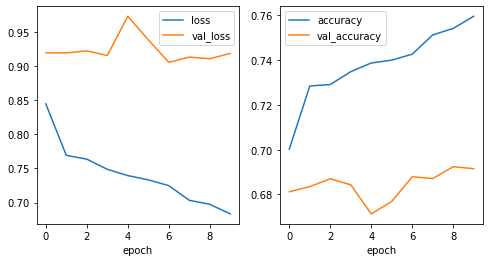

In [264]:
### Baseline

basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024,shuffle=True,
                  callbacks=[early_stopping]
                  )

basemodel.save('./saved_model/basemodel_aug.h5')


### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

Oh, now baseline model didn't imporove. Larger gap suggests me over fitting.
On the other hand, cnn_ae improved a lot, the learning curves between training and test stay consistent, which could be the benefit from encoder where only feature are extracted so my model was not affected by noise!